In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('../data/steam.csv')

# Encoding

In [3]:
# Convert owner range into numeric averages

def owners_to_num(x):
    low, high = x.split("-")
    return (int(low) + int(high)) / 2

df["owners_num"] = df["owners"].apply(owners_to_num)

In [4]:
# Drop unnecessary columns

df = df.drop(columns=['appid', 'name', 'release_date', 'developer', 'publisher', 'platforms', 'owners'], errors='ignore')

In [5]:
# drop the outlier game

df = df.drop(df["average_playtime"].idxmax())

In [6]:
# Creat new column playtime_group with pandas cut

bins = [0, 1, 10, 50, 200, df['average_playtime'].max() + 1]
labels = ['Very Short', 'Short', 'Medium', 'Long', 'Addictive']

df['playtime_group'] = pd.cut(df['average_playtime'], bins=bins, labels=labels, include_lowest=True)

print(df['playtime_group'].value_counts())

print("\nPercentage per group:")
print(df['playtime_group'].value_counts(normalize=True) * 100)


playtime_group
Very Short    21061
Addictive      3446
Long           1467
Medium          682
Short           418
Name: count, dtype: int64

Percentage per group:
playtime_group
Very Short    77.790500
Addictive     12.728079
Long           5.418483
Medium         2.519022
Short          1.543917
Name: proportion, dtype: float64


In [7]:
# Encode playtime groups into ordered numeric values
categories = [['Very Short', 'Short', 'Medium', 'Long', 'Addictive']]
ordinal_encoder = OrdinalEncoder(categories=categories)
df['playtime_group_encoded'] = ordinal_encoder.fit_transform(df[['playtime_group']]).astype(int)


In [8]:
# Convert multi-value text columns into binary features using MultiLabelBinarizer
text_cols = ['categories', 'genres', 'steamspy_tags']
df_final = df.copy()

for col in text_cols:
    if col in df_final.columns:
        df_final[col] = df_final[col].fillna('').astype(str).str.split(';')
        mlb = MultiLabelBinarizer()

        encoded_data = mlb.fit_transform(df_final[col])

        # استخدام classes_ بدل classes
        encoded_cols = pd.DataFrame(
            encoded_data,
            columns=[f"{col}_{c}" for c in mlb.classes_],
            index=df_final.index
        )

        df_final = pd.concat([df_final, encoded_cols], axis=1)
        df_final.drop(columns=[col], inplace=True)

In [9]:
#  Define the threshold for addictive games (top 10%)
addictive_threshold = df_final['average_playtime'].quantile(0.90)
print(f"Addictive threshold (90th percentile): {addictive_threshold:.2f}")

# Create target column
df_final['is_addictive'] = (df_final['average_playtime'] > addictive_threshold).astype(int)


Addictive threshold (90th percentile): 244.00


In [10]:
X = df_final.drop(columns=['average_playtime', 'is_addictive', 'median_playtime', 'english', 'price', 'required_age', 'playtime_group'], errors='ignore')
y = df_final['is_addictive']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# XGBoost Classifier

In [11]:
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

/home/shatha/.pyenv/versions/Game_Addictiveness/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [10:34:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'



(Accuracy): 0.9691

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7304
           1       0.80      0.93      0.86       819

    accuracy                           0.97      8123
   macro avg       0.90      0.95      0.92      8123
weighted avg       0.97      0.97      0.97      8123



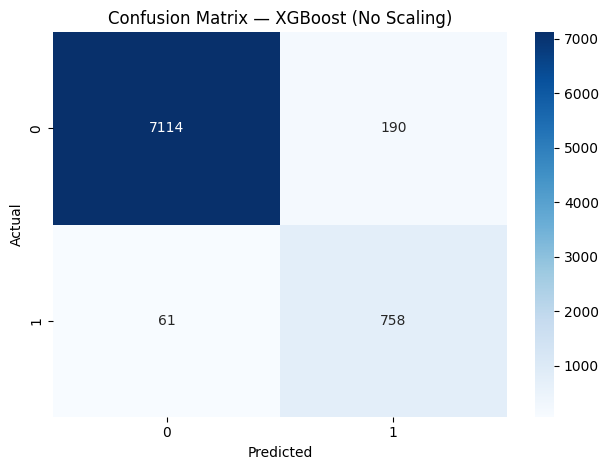

In [12]:
# Model Evaluation
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n(Accuracy): {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix — XGBoost (No Scaling)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


                            Feature  Importance
4            playtime_group_encoded    0.611958
3                        owners_num    0.047448
28   categories_Steam Trading Cards    0.025558
175      steamspy_tags_Free to Play    0.014889
44              genres_Free to Play    0.011113
2                  negative_ratings    0.005445
133             steamspy_tags_Crime    0.005239
1                  positive_ratings    0.005072
48     genres_Massively Multiplayer    0.004351
215       steamspy_tags_Local Co-Op    0.004272


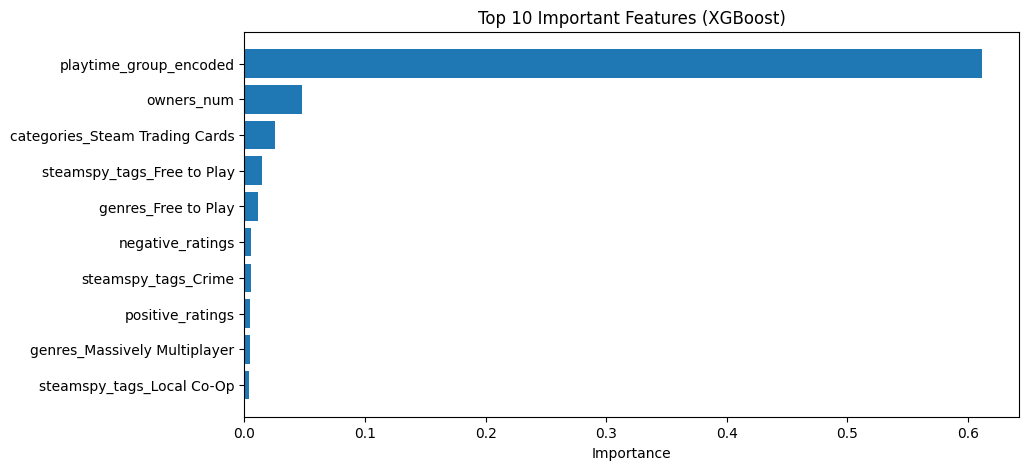

In [13]:
feature_names = X_train.columns
importances = xgb_model.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp.head(10))

plt.figure(figsize=(10,5))
plt.barh(feat_imp['Feature'].head(10), feat_imp['Importance'].head(10))
plt.gca().invert_yaxis()
plt.title('Top 10 Important Features (XGBoost)')
plt.xlabel('Importance')
plt.show()

# Test the model

In [14]:
# Create a new game for testing

new_game = pd.DataFrame([{
    'english': 1,
    'required_age': 0,
    'categories': 'Single-player;Online Multi-Player',
    'genres': 'Action;Shooter',
    'steamspy_tags': 'Multiplayer;First-Person;Shooter',
    'achievements': 20,
    'positive_ratings': 7000,
    'negative_ratings': 400,
    'average_playtime': 25000,
    'median_playtime': 1800,
    'price': 10,
    'owners_num': 800000,
    'playtime_group': 'Addictive'
}])

In [15]:
# Encode text columns (categories, genres, steamspy_tags) using the trained MultiLabelBinarizer
for col in text_cols:
    if col in new_game.columns:
        new_game[col] = new_game[col].fillna('').astype(str).str.split(';')


        new_game[col] = new_game[col].apply(lambda x: [i for i in x if i])

        encoded = pd.DataFrame(
            mlb.transform(new_game[col]),
            columns=[f"{col}_{c}" for c in mlb.classes_],
            index=new_game.index
        )

        new_game = pd.concat([new_game.drop(columns=[col]), encoded], axis=1)


/home/shatha/.pyenv/versions/Game_Addictiveness/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Online Multi-Player', 'Single-player'] will be ignored
  warnings.warn(


In [16]:
# Encode playtime_group using OrdinalEncoder and drop the original column
new_game['playtime_group_encoded'] = ordinal_encoder.transform(new_game[['playtime_group']]).astype(int)
new_game.drop(columns=['playtime_group'], inplace=True)


In [17]:
# Ensure new_game has the same columns
for col in X_train.columns:
    if col not in new_game.columns:
        new_game[col] = 0
new_game = new_game[X_train.columns]

In [18]:
# Prediction
prediction = xgb_model.predict(new_game)
proba = xgb_model.predict_proba(new_game)

In [19]:
print("Predicted Class (XGBoost):", "Addictive" if prediction[0] == 1 else "Not Addictive")
print(f"Probability of Not Addictive: {proba[0][0]*100:.2f}%")
print(f"Probability of Addictive: {proba[0][1]*100:.2f}%")

Predicted Class (XGBoost): Addictive
Probability of Not Addictive: 2.28%
Probability of Addictive: 97.72%


# Save the Model

In [20]:
df_original = pd.read_csv('../data/steam.csv')
outlier_game = df_original["average_playtime"].idxmax()
df_original = df_original.drop(df_original["average_playtime"].idxmax())

pred_all = xgb_model.predict(X)


In [21]:
df_original["is_addictive"] = pred_all

In [22]:
df_original["is_addictive"]

0        1
1        1
2        0
3        1
4        1
        ..
27070    0
27071    0
27072    0
27073    0
27074    0
Name: is_addictive, Length: 27074, dtype: int64

In [23]:
df_original.to_csv("../data/game_addictiveness.csv", index=False)

In [24]:
from joblib import dump
with open("../models/xgb_model_2025_10_27.pkl", "wb") as f:
    dump(xgb_model, f, protocol=5)